<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b> СОДЕРЖАНИЕ ПРОЕКТА. </b></font>

<font size=+1><b><a name='load-2'> [1. Загрузка данных.](#load) </a></b></font>

<font size=+1><b><a name='prepare-2'> [2. Предобработка данных.](#prepare) </a></b></font>     

1. Изменение типа данных (при необходимости).
2. Поиск пропущенных значений. При наличии таковых - описать возможные причины их возникновения и способы их заполнения.
3. Поиск дубликатов (явных и, при необходимости, - неявных).    

<font size=+1><b><a name='eda-2'> [3. Исследовательский анализ данных (EDA).](#eda) </a></b></font> 
    
Анализ описательных статистик, распределения данных в т.ч. с разбивкой по целевому признаку. Построение визуализаций распределения данных. При обнаружении аномальных значений - описать возможные причины их возникновения.
    
<font size=+1><b><a name='stat-2'> [4. Статистический анализ данных.](#stat) </a></b></font> 

Сформулировать и проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались. Также на основании EDA сформулировать и проверить аналогичные гипотезы для других нецелевых признаков.

<font size=+1><b><a name='cluster-2'> [5. Описание портретов клиентов, которые склонны уходить из банка.](#cluster) </a></b></font>    
    
1. На основании предыдущих результатов проекта принять решение о необходимости дополнительного математического анализа на данном этапе: кластеризации, логистической регрессии и т.д.
2. На основании всех предыдущих результатов описать портет (один или несколько) типичного клиента, который склонен уходить из банка.

<font size=+1><b><a name='summary-2'> [6. Выводы.](#summary) </a></b></font>    
    
<font size=+1><b><a name='conclusion-2'> [7. Заключение.](#conclusion) </a></b></font>   
    
Опираясь на выводы, описать рекомендации для уменьшения оттока пользователей.

</div>    

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='load'> [1. ЗАГРУЗКА ДАННЫХ.](#load-2) </a></b></font>

Ниже - описание загруженных данных:

- userid — идентификатор пользователя;
- score — баллы кредитного скоринга;
- City — город;
- Gender — пол;
- Age — возраст;
- Objects — количество объектов в собственности;
- Balance — баланс на счёте;
- Products — количество продуктов, которыми пользуется клиент;
- CreditCard — есть ли кредитная карта;
- Loyalty — активный клиент;
- estimated_salary — заработная плата клиента;
- Churn — ушёл или нет.
    
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
try:
    df = pd.read_csv('bank_dataset.csv')
except FileNotFoundError:
    df = pd.read_csv('https://drive.google.com/uc?export=download&id=1S3XHhuEbz4SOSKU_Rww0qoiS5NlKnTys')
    
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='prepare'> [2. ПРЕДОБРАБОТКА ДАННЫХ.](#prepare-2) </a></b></font>

<font size=+1><b> 2.1. Изменение типа данных. </b></font>

Прежде чем менять тип данных приведём названия столбцов к более привычному виду.
    
Касательно типа данных - на данном этапе кажутся необходимыми лишь изменения в столбцах 'user_id' и 'gender'
    
</div>

In [3]:
df.columns = df.columns.str.lower()

df = df.rename(columns={'userid':'user_id', 'creditcard': 'credit_card'})

df.head(1)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1


In [4]:
df['user_id'] = df['user_id'].astype('object')

df['gender'] = df['gender'].replace({'Ж': 0, 'М': 1})

df[['user_id', 'gender']].dtypes

user_id    object
gender      int64
dtype: object

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 2.2. Поиск пропущенных значений. </b></font>

Пропущенные значения есть лишь только в одном столбце - 'balance'. По имеющейся информации, упоминаемый баланс - это баланс дебетового счёта. Проверим это.    
    
</div>

In [5]:
display(df.query('credit_card == 1 and products == 1').head())

print('Количество клиентов с кредитной картой и одним продуктом:', 
      len(df.query('credit_card == 1 and products == 1')['balance']))

print('\nОписательные статистики для баланса клиентов с кредитной картой и одним продуктом:\n',
      df.query('credit_card == 1 and products == 1')['balance'].describe())

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,0,42,2,NaN,1,1,1,101348.88,1
4,15780624,850,Рыбинск,0,43,2,125510.82,1,1,1,79084.10,0
9,15635125,684,Ярославль,1,27,2,134603.88,1,1,1,71725.73,0
16,15780188,653,Ростов Великий,1,58,1,132602.88,1,1,0,5097.67,1
22,15742045,510,Рыбинск,0,38,4,NaN,1,1,0,118913.53,1


Количество клиентов с кредитной картой и одним продуктом: 3578

Описательные статистики для баланса клиентов с кредитной картой и одним продуктом:
 count      2921.000000
mean     119668.745799
std       30006.641813
min       16893.590000
25%      100375.390000
50%      120105.430000
75%      139561.460000
max      221532.800000
Name: balance, dtype: float64


In [6]:
display(df.query('balance > 0 and products == 1').head())

print('\nОписательные статистики для баланса клиентов с балансом > 0 и одним продуктом:\n',
      df.query('balance > 0 and products == 1')['credit_card'].describe())

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
1,15690047,608,Рыбинск,0,41,1,83807.86,1,0,1,112542.58,0
4,15780624,850,Рыбинск,0,43,2,125510.82,1,1,1,79084.10,0
9,15635125,684,Ярославль,1,27,2,134603.88,1,1,1,71725.73,0
16,15780188,653,Ростов Великий,1,58,1,132602.88,1,1,0,5097.67,1
26,15779552,756,Ростов Великий,1,36,2,136815.64,1,1,1,170041.95,0



Описательные статистики для баланса клиентов с балансом > 0 и одним продуктом:
 count    4179.000000
mean        0.698971
std         0.458760
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: credit_card, dtype: float64


In [7]:
#df['balance_bool'] = pd.isna(df['balance'])

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 2.2. Поиск пропущенных значений (продолжение). </b></font>

Выше - исследование двух срезов данных. В первый из них включены те клиенты, у которых есть кредитная карта и только один банковский продукт. Если бы информация о том, что balance - это дебетовый баланс, была бы верна, то значение данного признака у клиентов среза отсутствовало бы (ввиду остутсвия собственно дебетового продукта). Однако, у 2921 клиента из 3578 в срезе ненулевые значения balance (минимально - 16893.59).
    
Во второй срез включены те пользователи, у которых есть положительное значение признака balance и только один банковский продукт. Используя всё тоже предположение о признаке balance как балансе дебетового счёта, можно предположить, что у клиентов среза не должно быть кредитной карты. Однако, в реальности кредитная карта есть у 70% клиентов, попавших в срез (описательная статистика mean для признака со значениями 0 и 1 фактически равна доле наблюдений со значением 1).
    
Альтернативные предположение о том, что balance - это (1) баланс кредитной карты или (2) суммарный баланс дебетовых и кредитных карт также не подтверждаются. Если бы какое-то из них было бы верно, то у клиентов, попавших в первый срез данных не было пропусков в признаке balance; в реальности значения для balance указаны для 2921 клиентов из 3578 в срезе.
    
Возможно, есть неизвестные особенности в методологии подсчёта количества продуктов (признак products) - могут не учитываться дебетовые или кредитные карты. В любом случае, без дополнительных комментариев происхождение пропусков признака balance неясно. В связи с этим, данные пропуски не будут заполнятся, а признак не будет включён в дальнейший анализ.
    
</div>

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 2.3. Поиск дубликатов. </b></font>

Явных дубликатов в датасете нет.
    
Для дальнейших этапов создадим сводную таблицу по признакам. Заполним первый её столбец количеством уникальных значений каждого признака.По этим данным видно, что есть признаки с малым количеством уникальных значений: признак city с тремя уникальными значениями и четыре бинарных признака. При вызове метода display() для срезов из пункта 2.2 действительно видно, что в city представлены три названия различных городов ('Рыбинск', 'Ярославль' и 'Ростов Великий', а 4 бинарных признака используют только значения 0 и 1.
    
Для других признаков поиск неявных дубликатов не имеет смысла.
    
</div>

In [8]:
df.duplicated().sum()

0

In [9]:
counts = []

for c in df.columns:
    counts.append(df[c].nunique())
    
counts

[10000, 460, 3, 2, 70, 11, 6381, 4, 2, 2, 9999, 2]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  object 
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  int64  
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [11]:
features = pd.DataFrame(df.columns)
features['1'] = counts
features = features.sort_values(by='1', ascending=False, ignore_index=True)
features.columns = ('feature', 'nunique')

features

,feature,nunique
0,user_id,10000
1,estimated_salary,9999
2,balance,6381
3,score,460
4,age,70
5,objects,11
6,products,4
7,city,3
8,gender,2
9,credit_card,2


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='eda'> [3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA).](#eda-2) </a></b></font>

<font size=+1><b> 3.1. Анализ описательных статистик. </b></font>

Заполним сводную таблицу по признакам описательным статистиками: в целом по выборке и в разбивке по целевому признаку churn.
    
</div>

In [12]:
mean = []
mean_0 = []
mean_1 = []

for c in features['feature']:
    if df[c].dtypes in ['int64', 'float64']:
        mean.append(round(df[c].mean(), 2))
        mean_0.append(round(df.query('churn == 0')[c].mean(), 2))
        mean_1.append(round(df.query('churn == 1')[c].mean(), 2))
    else:
        mean.append(np.nan)
        mean_0.append(np.nan)
        mean_1.append(np.nan)

In [13]:
features['mean'] = mean
features['mean_0'] = mean_0
features['mean_1'] = mean_1

features

,feature,nunique,mean,mean_0,mean_1
0,user_id,10000,NaN,NaN,NaN
1,estimated_salary,9999,100090.24,99738.39,101465.68
2,balance,6381,119827.49,119535.86,120746.97
3,score,460,650.53,651.85,645.35
4,age,70,38.92,37.41,44.84
5,objects,11,5.01,5.03,4.93
6,products,4,1.53,1.54,1.48
7,city,3,NaN,NaN,NaN
8,gender,2,0.55,0.57,0.44
9,credit_card,2,0.71,0.71,0.70


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 3.1. Анализ описательных статистик (продолжение). </b></font>

Практически по всем признакам есть разница между группами, разбитыми по целевому бинарному признаку churn. Для каких-то признаков эта разница более заметна, а именно для: age, gender, loyalty. Уделим этим признакам большее внимание при анализе визуализаций распределения.

<font size=+1><b> 3.2. Анализ визуализаций распределения данных. </b></font>

Анализ распределения признака user_id бесполезен: user_id - это всего лишь уникальный идентификатор пользователя; наличие его в таблице features необходимо лишь для подтверждения того, что в датасете 10000 уникальных значений этих идентификаторов (по количестве строк).
    
По описанным причинам начнём анализ визуализаций с признака estimated_salary. Распределение этого признака довольно "плоское", без заметных различий по группам churn.    
    
</div>

In [14]:
plt.style.use('classic')

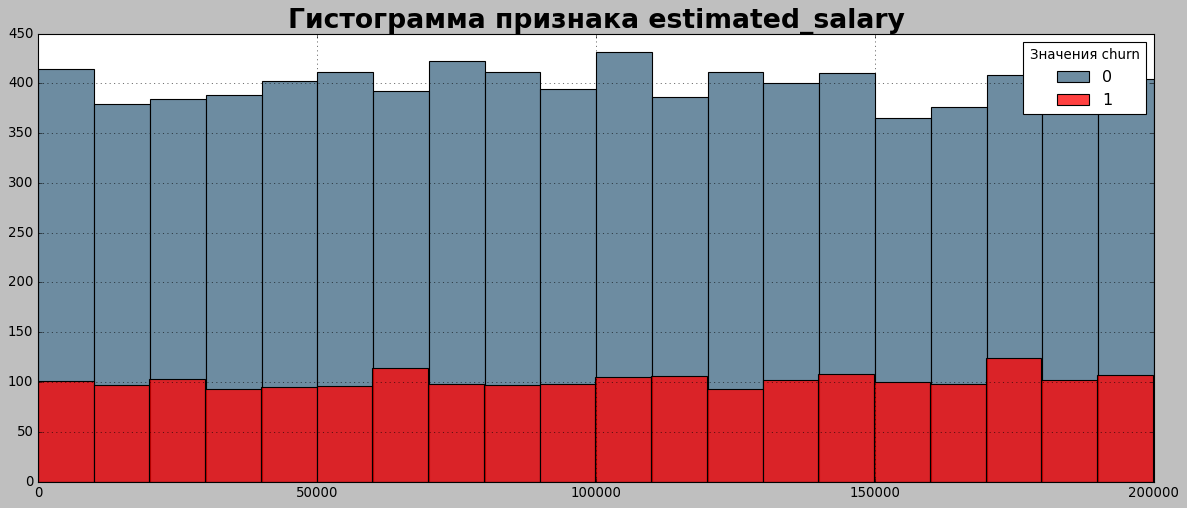

In [15]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['estimated_salary'], bins=20, color='#3c6682')
sns.histplot(df.query('churn == 1')['estimated_salary'], bins=20, color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака estimated_salary', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 3.2. Анализ визуализаций распределения данных (продолжение). </b></font>

Визуально распределение признака balance похоже на нормальное, без аномалий и заметных различий по группам. Этот признак не будет дальше использоваться в статистическом анализе, однако важно было рассмотреть его распределение для поиска аномальных данных.
    
Распределение признака score также похоже на нормальное, но с выбивающимися значениями справа (возможно, это максимально возможное значение кредитного скоринга). Есть различия по группам churn в левой части распределения, но в целом распределения очень похожи.    
    
</div>

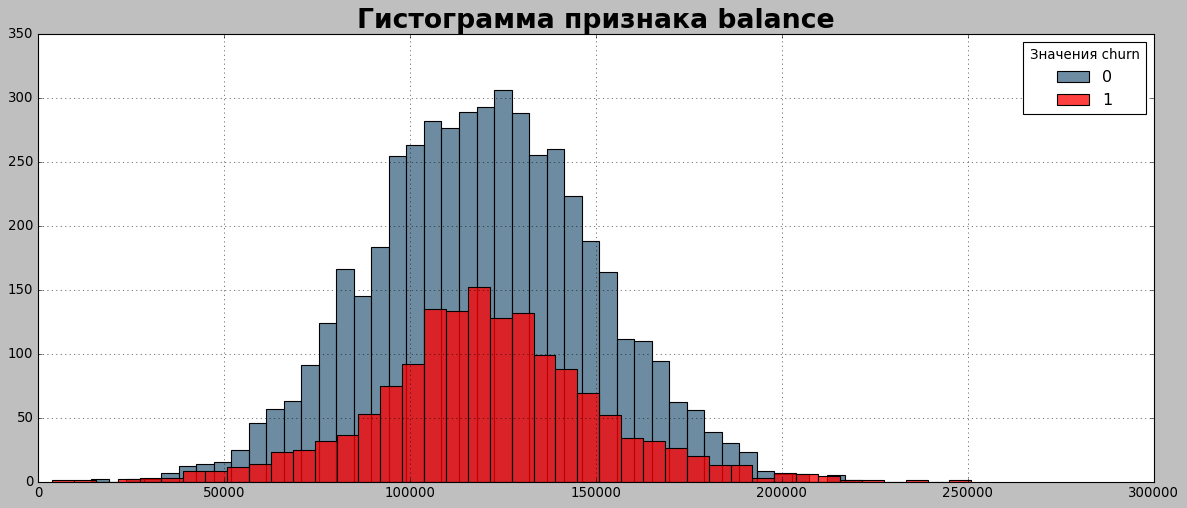

In [16]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['balance'], color='#3c6682')
sns.histplot(df.query('churn == 1')['balance'], color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака balance', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

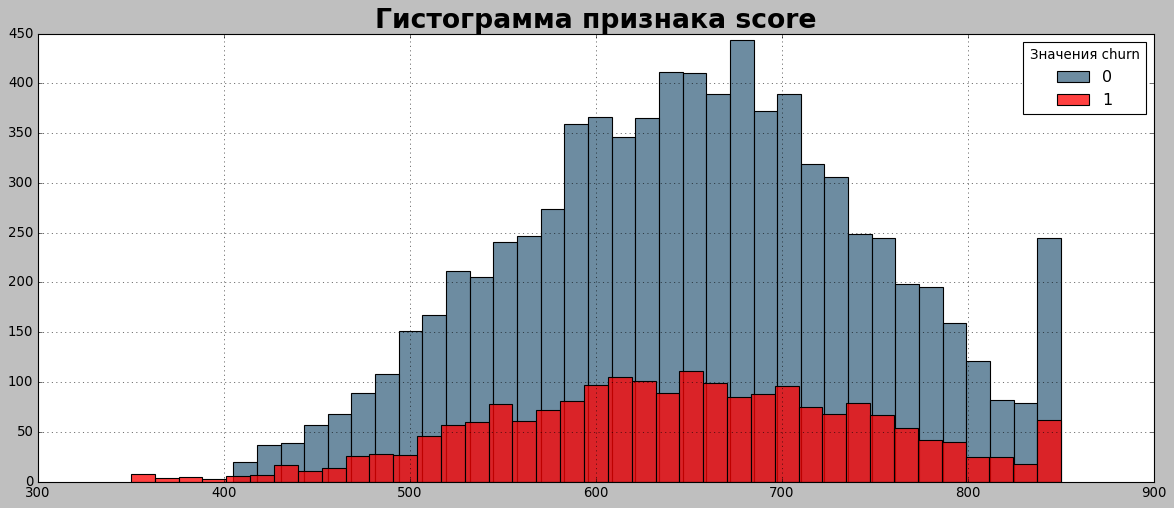

In [17]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['score'], bins=35, color='#3c6682')
sns.histplot(df.query('churn == 1')['score'], bins=39, color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака score', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 3.2. Анализ визуализаций распределения данных (продолжение). </b></font>

Признак age - первый признак, для которого явно видны различия для групп churn: пик распределения для оставшихся пользователей расположен правее, нежели для ушедших.
    
Для признака objects наблюдается почти "плоское распределение" - исключение составляют лишь крайние значения. Различий между группами churn не наблюдается.
    
</div>

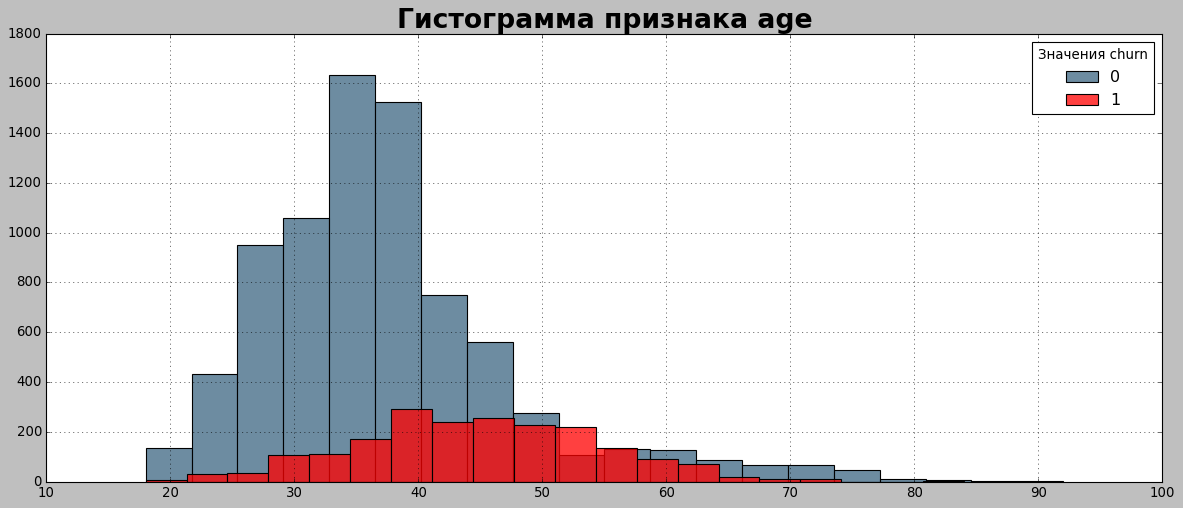

In [18]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['age'], bins=20, color='#3c6682')
sns.histplot(df.query('churn == 1')['age'], bins=20, color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака age', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

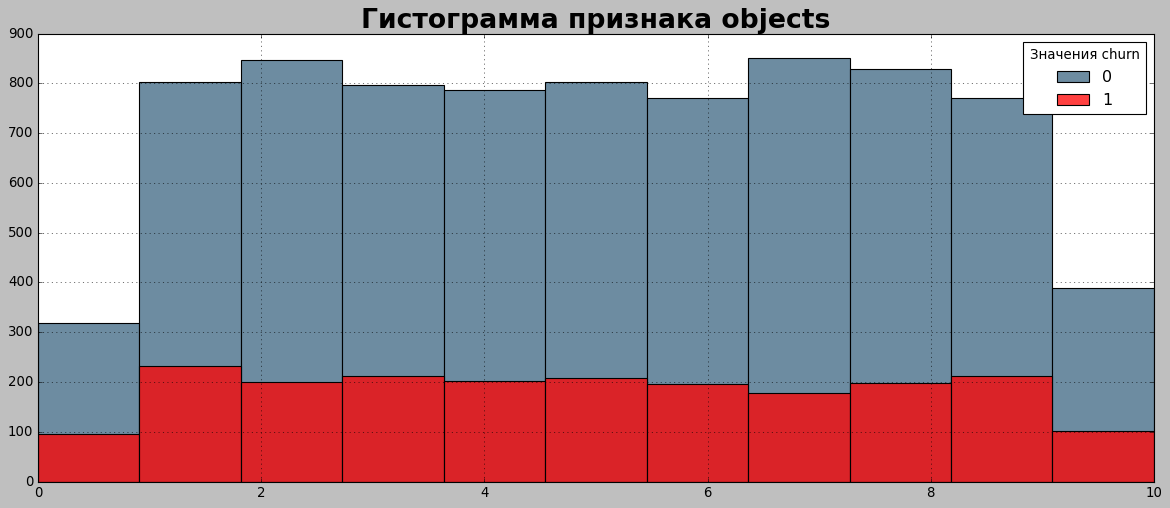

In [19]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['objects'], bins=11, color='#3c6682')
sns.histplot(df.query('churn == 1')['objects'], bins=11, color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака objects', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 3.2. Анализ визуализаций распределения данных (продолжение). </b></font>

Для признака products заметна разница в распределении: для клиентов, которые остаются, самое распространённое количество продуктов - 2; количество оставшихся клиентов с одним продуктом меньше. Для уходяших же клиентов распределение убывающее: больше всего ушедших клиентов с одним продуктом; меньше - с двумя продуктами и т.д. Это интересное наблюдение, так разницы в средних значениях между группами по таблице features не обнаружено.
    
Для признака city, по которому не было данных о средних значениях, заметны различия по группам churn: среди оставшихся клиентов  больше всего жителей Ярославля, жителей двух других городов примерно поровну; среди ушедших клиентов меньше всего жителей Рыбинска, жителей двух других городов примерно поровну.   
    
</div>

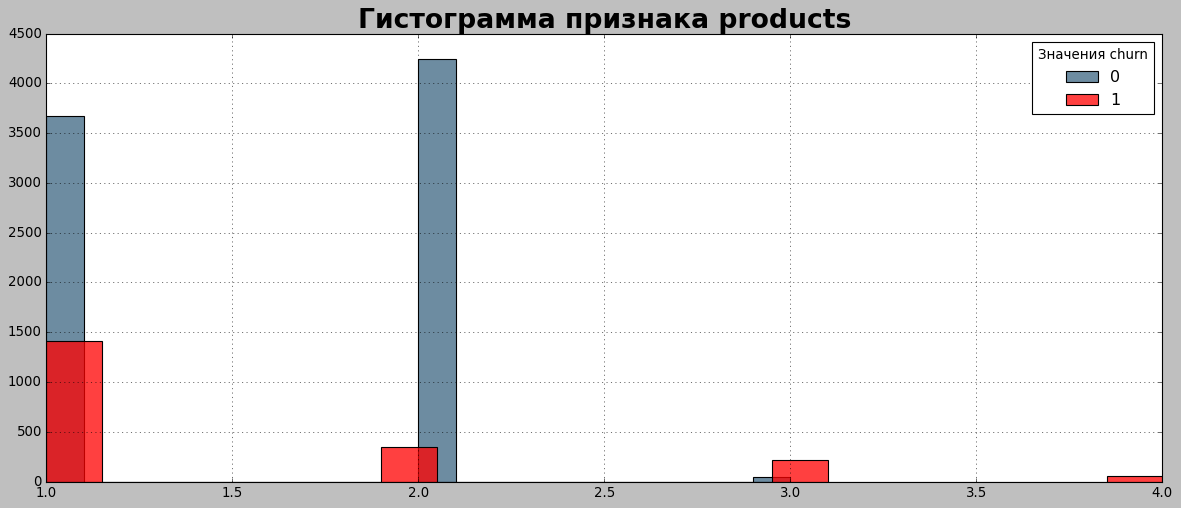

In [20]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['products'], color='#3c6682')
sns.histplot(df.query('churn == 1')['products'], color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака products', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

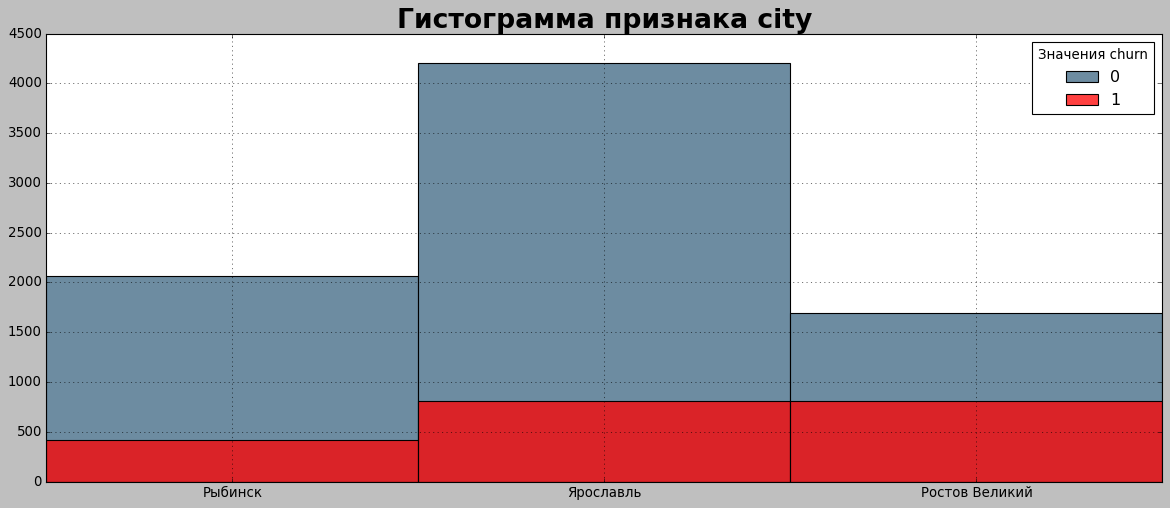

In [21]:
plt.figure(figsize=(18, 7))
sns.histplot(df.query('churn == 0')['city'], bins=11, color='#3c6682')
sns.histplot(df.query('churn == 1')['city'], bins=11, color='red')
plt.xlabel('')
plt.ylabel('')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Гистограмма признака city', fontsize=24, color='black', fontweight='semibold')
plt.grid()
plt.legend(['0', '1'], title='Значения churn')
plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 3.2. Анализ визуализаций распределения данных (продолжение). </b></font>

Оставшиеся три признака (gender, credit_card и loyalty) - бинарные. О различиях в распределении здесь можно говорить для признаков gender (для оставшихся клиентов количество мужчин больше, чем количество женщин; для ушедших клиентов - ситуация обратная) и loaylty (для оставшихся клиентов количество активных клиентов больше, чем количество неактивных; для ушедших клиентов - ситуация обратная).
    
</div>

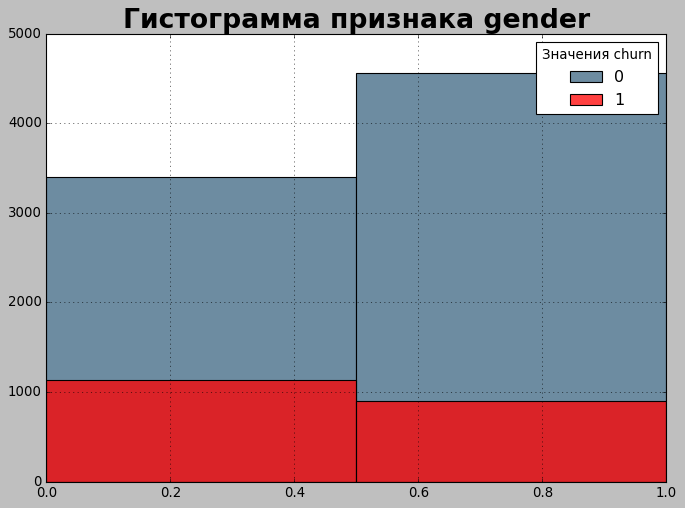

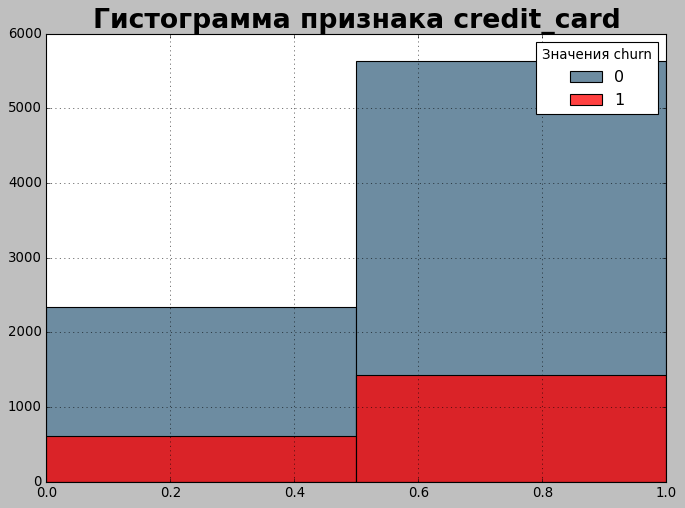

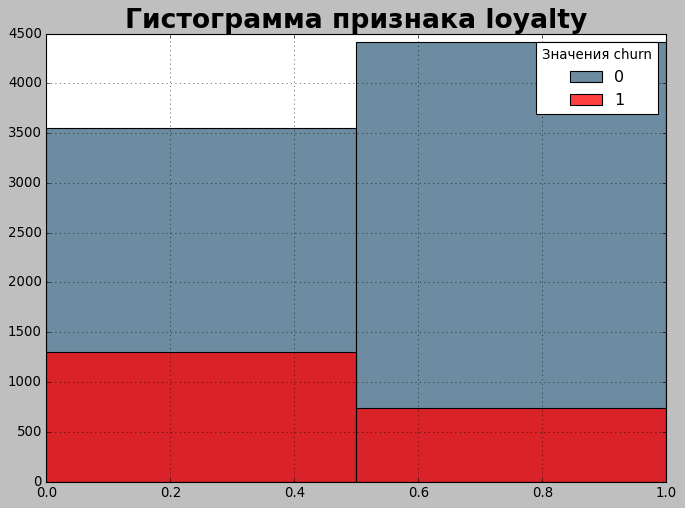

In [22]:
for c in ['gender', 'credit_card', 'loyalty']:
    plt.figure(figsize=(10, 7))
    sns.histplot(df.query('churn == 0')[c], bins=2, color='#3c6682')
    sns.histplot(df.query('churn == 1')[c], bins=2, color='red')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.title(f'Гистограмма признака {c}', fontsize=24, color='black', fontweight='semibold')
    plt.grid()
    plt.legend(['0', '1'], title='Значения churn')
    plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 3.3. Выводы по EDA. </b></font>

В дальнейшем статистическом анализе есть смысл исследовать различия пользователей по следующим признакам: age, city, gender и loaylity. Также можно добавить в статистический анализ признак products.    
    
Аномальных данных в ходе EDA не обнаружено.
    
</div>

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='stat'> [4. СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАННЫХ.](#stat-2) </a></b></font>

<font size=+1><b> 4.1. Обзор признаков для анализа. </b></font>

Рассмотрим каждый из признаков, для которых планируется проводиться статистический анализ:
    
1. В техническом задании указано, что признак estimated_salary в любом случае необходимо проверить в рамках статистического анализа. Для его его проверки будет использован T-критерий Стюдента или U-критерий Манна — Уитни. Выбор критерия будет произведён после исследования сравниваемых выборок критерием согласия Колмогорова.
2. Признак age (и другие признаки далее) выбран для статистического анализа после EDA. В остальном - аналогично предыдущему пункту.
3. Выбор статистического критерия для признака products - аналогично пункту 1.    
4. Признак gender является категориальным и бинарным. Вследствие этого, исследование различий по группам оттока с помощью T-критерия Стюдента (или U-критерий Манна — Уитни) не выглядит оптимальным. С другой стороны, можно вспомнить, что среднее значение признака gender для выборки фактически равно доле наблюдений с значением признака = 1. Учитывая этот факт, можно разницу средних для данного признака можно проверить с помощью Z-теста для сравнения равенства долей. Оптимально для этого написать пользовательскую функцию.
5. Выбор статистического критерия для признака loaylity - аналогично предыдущему пункту.
6. Следующий признак city - также категориальный, но при этом он не является бинарным, поэтому Z-тест в данном случае не подойдёт. Можно было бы разделить данный признак на три отдельных бинарных признака (со значениями 0("НЕ Ярославль") - 1("Ярославль) и т.д.), но это не оптимальный выход. Во-первых, данные бинарные признаки не так хорошо интерпретируются. Во-вторых, это увеличит количество статистических сравнений на 3, а это может быть критичным так как мы в любом случае будем использовать поправку на множественные сравнения, и дополнительные сравнения уменьшат уровень значимости alpha для каждого единичного сравнения. В связи с этим, признак city не будет исследоваться с помощью статистических критериев.
    
Выше упоминались поправки на множественные сравнения. В данном проекте для этой цели будет использоваться поправка Шидака для использования которой напишем пользовательскую функцию.
    
</div>

In [23]:
def z_test(size_a, part_a, size_b, part_b):
    p_a = part_a / size_a
    p_b = part_b / size_b
    p_total = (part_a + part_b) / (size_a + size_b)
    
    z_value = (p_a - p_b) / math.sqrt(p_total * (1-p_total) * (1/size_a + 1/size_b))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [24]:
def sidak_correction(group_alpha, number):
    single_alpha = 1 - (1 - group_alpha) ** (1/number)
    return single_alpha

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 4.2. Проверки распределений на нормальность. </b></font>

Для выбора критерия проверки различий средних значений признаков estimated_salary, age и products по группам оттока необходимо провести проверку исследуемых выборок с помощью критерия согласия Колмогорова. С помощью данного критерия мы сможем узнать, отличается ли распределение в данной выборке от нормально или нет. Если обе выборки, средние значения которых нужно сравнить, распределены нормально, то мы можем использовать для сравнения средних Т-критерий. В противном случае нужно использовать U-критерий.
    
Для проверки каждой из 6 выборок будут справедливы следующие формулировки статистических гипотез:
- Нулевая гипотеза: выборочное распределение не отличается от нормального распределения.
- Альтернативная гипотеза: выборочное распределение отлично от нормального распределения.

Также установим уровень значимости alpha = 0.05 для наших проверок.
    
Ни одна из 6 сравниваемыех выборок не распределена нормально, следовательно, далее будет использоваться U-критерий Манна — Уитни.    
    
</div>

In [25]:
for f in ['estimated_salary', 'age', 'products']:
    for n in [0, 1]:
        print(f'P-value критерия Колмогорова для признака {f} со значением churn = {n}:',
              st.kstest(list(df.query('churn == @n')[f]), 'norm')[1])

P-value критерия Колмогорова для признака estimated_salary со значением churn = 0: 0.0
P-value критерия Колмогорова для признака estimated_salary со значением churn = 1: 0.0
P-value критерия Колмогорова для признака age со значением churn = 0: 0.0
P-value критерия Колмогорова для признака age со значением churn = 1: 0.0
P-value критерия Колмогорова для признака products со значением churn = 0: 0.0
P-value критерия Колмогорова для признака products со значением churn = 1: 0.0


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 4.3. Формулировка гипотез. </b></font>

Сформулируем нулевые и альтернативные гипотезы для сравнения каждого из признаков:
1. Признак estimated_salary, нулевая гипотеза: нет различий между уровнями заработной платы ушедших и оставшихся клиентов; альтернативная гипотеза: есть различия между уровнями заработной платы ушедших и оставшихся клиентов.
2. Признак age, нулевая гипотеза: нет различий между уровнями возраста ушедших и оставшихся клиентов; альтернативная гипотеза: есть различия между уровнями возраста ушедших и оставшихся клиентов.
3. Признак products, нулевая гипотеза: нет различий между уровнями количества банковских продуктов ушедших и оставшихся клиентов; альтернативная гипотеза: есть различия между уровнями количества банковских продуктов ушедших и оставшихся клиентов.   
4. Признак gender, нулевая гипотеза: доли мужчин в группах ушедших и оставшихся клиентов равны; альтернативная гипотеза: доли мужчин в группах ушедших и оставшихся клиентов различны.
5. Признак loyalty, нулевая гипотеза: доли активных клиентов в группах ушедших и оставшихся клиентов равны; альтернативная гипотеза: доли активных клиентов в группах ушедших и оставшихся клиентов различны.

<font size=+1><b> 4.4. Сравнение средних. </b></font>

Проведём проверку данных гипотез с ипользованием описанных выше статистических критерий, поправки на 5 сравнений и уровнем групповой значимости = 0.05.    
    
</div>

In [26]:
sidak_5 = sidak_correction(0.05, 5)

In [27]:
for f in ['estimated_salary', 'age', 'products']:
    p_value = st.mannwhitneyu(df.query('churn == 0')[f], df.query('churn == 1')[f])[1]
    if p_value >= sidak_5:
        print('Нулевая гипотеза верна: нет различий между уровнями {0} ушедших и оставшихся клиентов, p_value = {1:.2f}\n'
              .format(f, p_value))
    else:
        print('Отвергаем нулевую гипотезу: есть различия между уровнями {0} ушедших и оставшихся клиентов, p_value = {1:.2f}\n'
              .format(f, p_value))

Нулевая гипотеза верна: нет различий между уровнями estimated_salary ушедших и оставшихся клиентов, p_value = 0.23

Отвергаем нулевую гипотезу: есть различия между уровнями age ушедших и оставшихся клиентов, p_value = 0.00

Отвергаем нулевую гипотезу: есть различия между уровнями products ушедших и оставшихся клиентов, p_value = 0.00



In [28]:
gender_value = z_test(len(df.query('churn == 0')), len(df.query('churn == 0 and gender == 1')), len(df.query('churn == 1')), 
          len(df.query('churn == 1 and gender == 1')))

if gender_value >= sidak_5:
    print('Нулевая гипотеза верна: доли мужчин для ушедших и оставшихся клиентов равны, p_value = {0:.2f}\n'
              .format(gender_value))
else:
    print('Отвергаем нулевую гипотезу: доли мужчин для ушедших и оставшихся клиентов различны, p_value = {0:.2f}'
              .format(gender_value))

Отвергаем нулевую гипотезу: доли мужчин для ушедших и оставшихся клиентов различны, p_value = 0.00


In [29]:
loyalty_value = z_test(len(df.query('churn == 0')), len(df.query('churn == 0 and loyalty == 1')), len(df.query('churn == 1')), 
          len(df.query('churn == 1 and loyalty == 1')))

if loyalty_value >= sidak_5:
    print('Нулевая гипотеза верна: доли активных клиентов для ушедших и оставшихся клиентов равны, p_value = {0:.2f}\n'
              .format(loyalty_value))
else:
    print('Отвергаем нулевую гипотезу: доли активных клиентов для ушедших и оставшихся клиентов различны, p_value = {0:.2f}'
              .format(loyalty_value))

Отвергаем нулевую гипотезу: доли активных клиентов для ушедших и оставшихся клиентов различны, p_value = 0.00


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 4.5. Выводы. </b></font>

Обнаружены значимые различия между средними значениями между группами оттока по признакам age, products, gender и loaylity. Не обнаружено значимых различий для признака estimated_salary.  
    
</div>

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='cluster'> [5. ОПИСАНИЕ ПОРТРЕТОВ КЛИЕНТОВ, КОТОРЫЕ СКЛОННЫ УХОДИТЬ ИЗ БАНКА.](#cluster-2) </a></b></font>

<font size=+1><b> 5.1. Обоснование необходимости кластерного анализа. </b></font>

В предыдущем пункте было описано 4 признака, по которым были обнаружены значимые статистические различия. Однако, это не значит что данные статистические факты применимы для каждого пользователя, ушедшего или оставшегося. Значимые различия - это описание средней тенденции; на деле можно найти довольно большие группы наблюдений, которые будут отличаться от остальных не по всем указанным нами признаками, а только лишь парой из них или вовсе только одним. В нахождении таких групп поможет кластерный анализ.
    
Среди других методов машинного обучения могла бы помочь логистическая регрессия. Ценность данного метода в первую очередь в том, что он позволяет предсказывать целевой бинарный признак (отток в нашем случае) на основании линейной регрессии. Такая задача перед нами прямо сейчас не стоит. Однако, анализ весов в уравнении линейной регрессии мог бы помочь оценить "важность" вклада признаков в значение целевого признака; можно было бы проранжировать признаки со статистическими различиями по модулю веса. Но, на мой взгляд, данный анализ всё же выглядит избыточно.
    
<font size=+1><b> 5.2. Подготовка данных для кластерного анализа. </b></font>  
    
Прежде чем перейти непосредственно к процедуре кластерного анализа, нужно подготовить данные. В частности, так как мы исследуем портрет ушедших клиентов банка, то будет необходим соотвествующий срез данных.
    
Кроме того, в проекте описывались сложности с анализом различий по признаку city. Идея преобразовать признак city в три бинарных признака для нужд кластерного анализа выглядит более обосновано. С другой стороны, это может привести в дублированию данных: выделенные кластеры просто разделяться по разным городам. Проверим удачность этого решения с помощью исследования матрицы корреляций признаков.
    
</div>

In [30]:
clusters = df.query('churn == 1').drop(columns=['user_id', 'balance', 'churn'])

clusters = pd.get_dummies(clusters, columns=['city'])

clusters.head(1)

,score,gender,age,objects,products,credit_card,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,619,0,42,2,1,1,1,101348.88,0,0,1


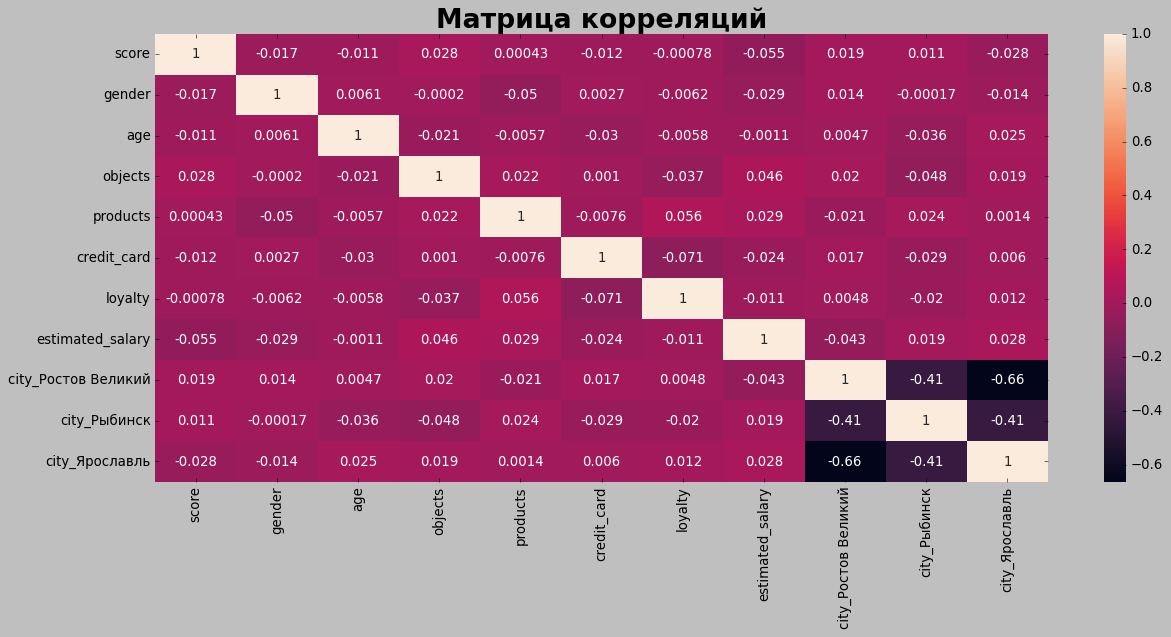

In [31]:
plt.figure(figsize=(18, 7))
sns.heatmap(clusters.corr(), annot=True)
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Матрица корреляций', fontsize=24, color='black', fontweight='semibold')
plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 5.2. Подготовка данных для кластерного анализа (продолжение). </b></font>  
    
Как видно из матрицы, единственные коррелярующие признаки - это как раз признаки принадлежности к городам. Таким образом, принадлежность к городу придётся исключить и из этого анализа.
    
Кроме того, необходимо нормализовать все данные.
    
</div>

In [32]:
clusters = clusters.drop(columns=['city_Ростов Великий', 'city_Рыбинск', 'city_Ярославль'])

In [33]:
sc = StandardScaler()
clusters_sc = sc.fit_transform(clusters)

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 5.3. Выбор количества кластеров. </b></font>

Для определения количества кластеров проведём агломеративную иерархическую кластеризацию и нарисуем дендрограмму. 
    
Алгоритм предлагает нам четырёхкластерное решение. Действительно, можно заметить относительно большой "разрыв" дендрограммы наблюдается между 4- и 5-кластерными решениями. Таким образом, проведём сначала кластеризацию с числом кластеров = 4; если полученные класетры будет затруднительно интерпретировать, то можно попробовать более многокластерное решение.

</div>

In [34]:
linked = linkage(clusters_sc, method = 'ward')

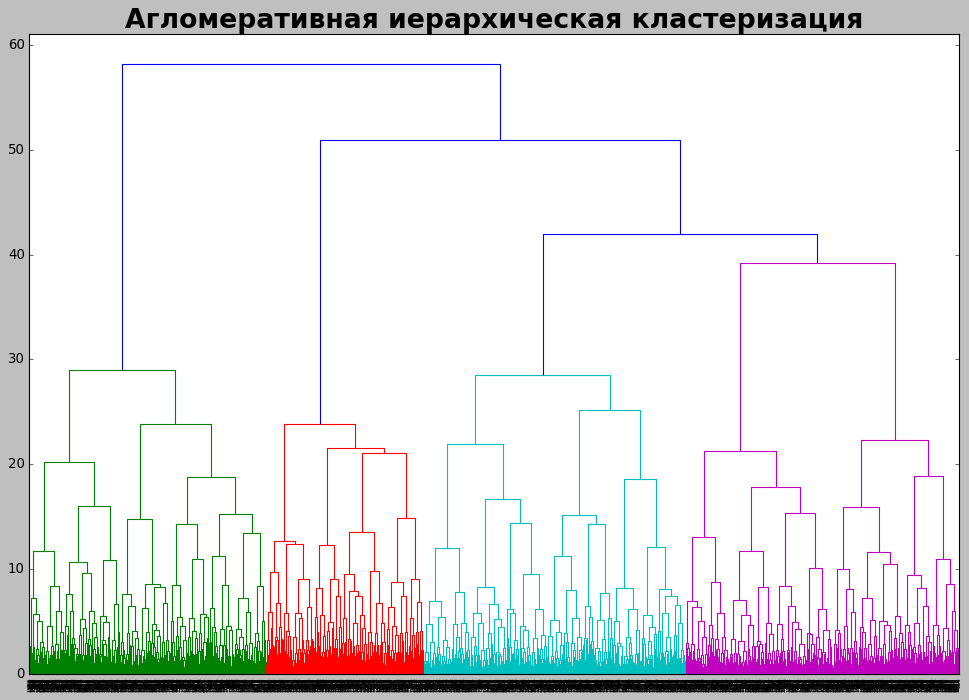

In [35]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('Агломеративная иерархическая кластеризация', fontsize=24, color='black', fontweight='semibold')
plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 5.4. Кластерный анализ. </b></font>

Проведём кластерный анализ. Заметим, что кластеры получились неравными по размеру (количеству включенных в них наблюдений), но всё же среди них нет крайне большого или маленького. 
    
</div>

In [36]:
km_4 = KMeans(n_clusters=4)

labels = km_4.fit_predict(clusters_sc)

In [37]:
clusters['cluster'] = labels

clusters.tail()

,score,gender,age,objects,products,credit_card,loyalty,estimated_salary,cluster
9981,498,1,42,3,1,1,1,53445.17,2
9982,655,0,46,7,1,1,0,115146.40,0
9991,597,0,53,4,1,1,0,69384.71,0
9997,709,0,36,7,1,0,1,42085.58,3
9998,772,1,42,3,2,1,0,92888.52,0


In [38]:
clusters.groupby('cluster').agg({'score': 'count'})

,score
cluster,
0,822
1,280
2,405
3,530


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+1><b> 5.5. Интерпретация кластеров. </b></font>

Согласно проведённому кластерному анализу можно выделить следующие группы клиентов:
    
- Кластер 0: клиенты, пользовавшиеся большим количеством кредитных продуктов (самый маленький кластер).
- Кластер 1: лояльные, но тем не менее ушедшие клиенты.
- Кластер 2: нелояльные женщины.
- Кластер 3: нелояльные мужчины.

#Вопрос для ревьюера: стоит ли указывать результаты других кластерных анализов?  Я провел в общей сумме не меньше 4 кластерных анализов с разными изменения на пунктах 5.2 - 5.4, но указал самый интерпретабельный вариант. С одной стороны, это лучше объясняет ход рассуждений, с другой стороны, это захламляет проект и может очень сильно запутать.   
    
</div>

In [39]:
clusters.groupby('cluster').mean().T

cluster,0,1,2,3
score,644.620438,645.675000,643.649383,647.615094
gender,0.454988,0.403571,0.424691,0.450943
age,44.849148,44.696429,44.441975,45.198113
objects,4.986618,5.092857,4.703704,4.939623
products,1.177616,3.214286,1.222222,1.211321
credit_card,1.000000,0.703571,1.000000,0.000000
loyalty,0.000000,0.407143,1.000000,0.407547
estimated_salary,100852.872859,106345.273571,96780.218025,103418.601396


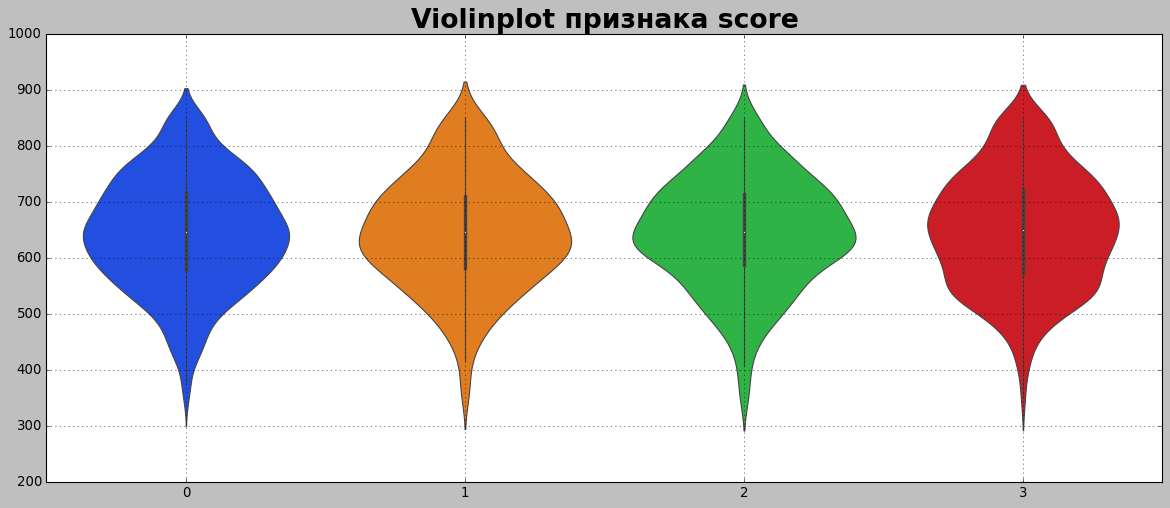

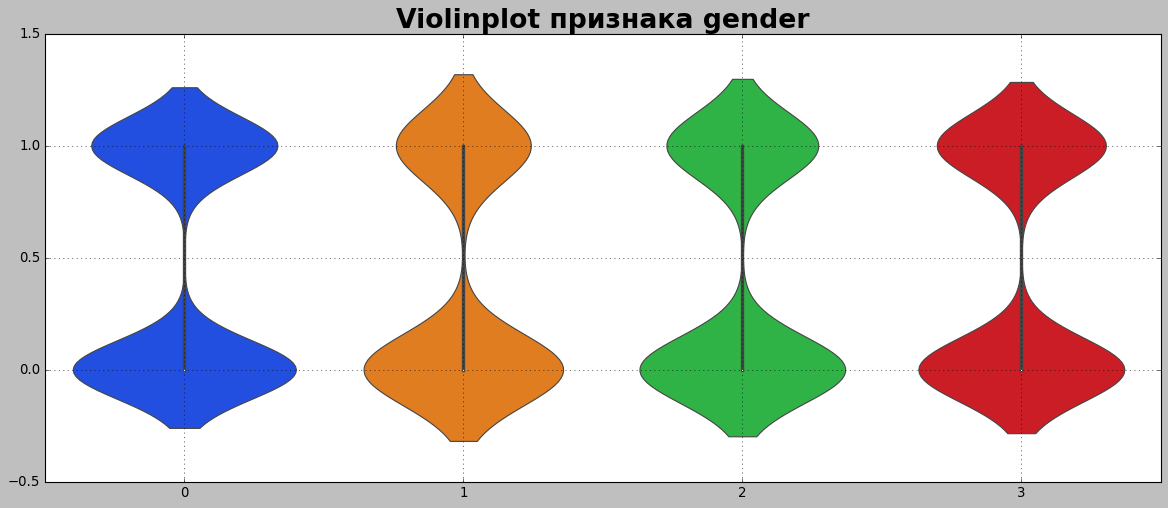

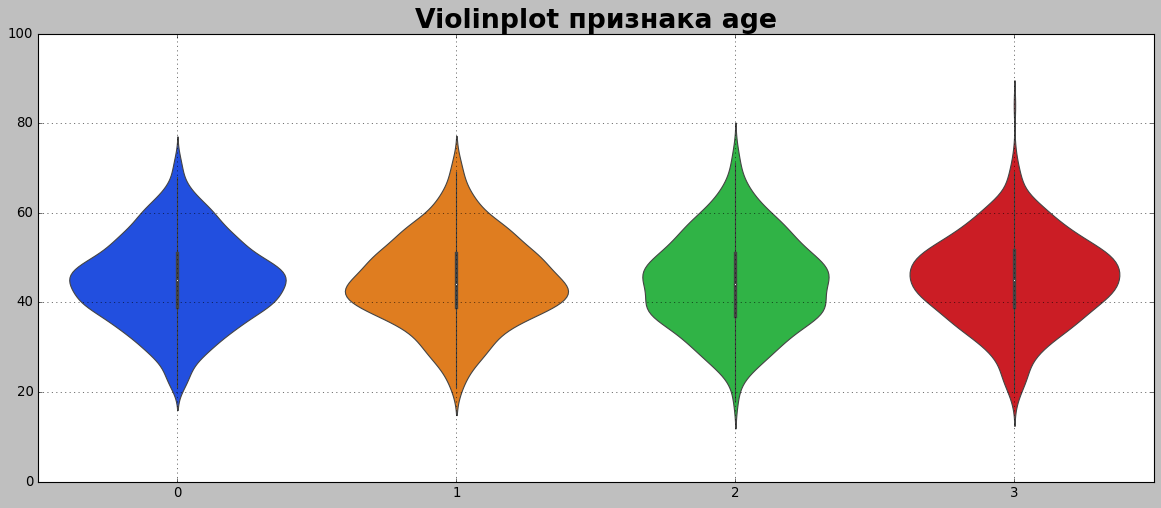

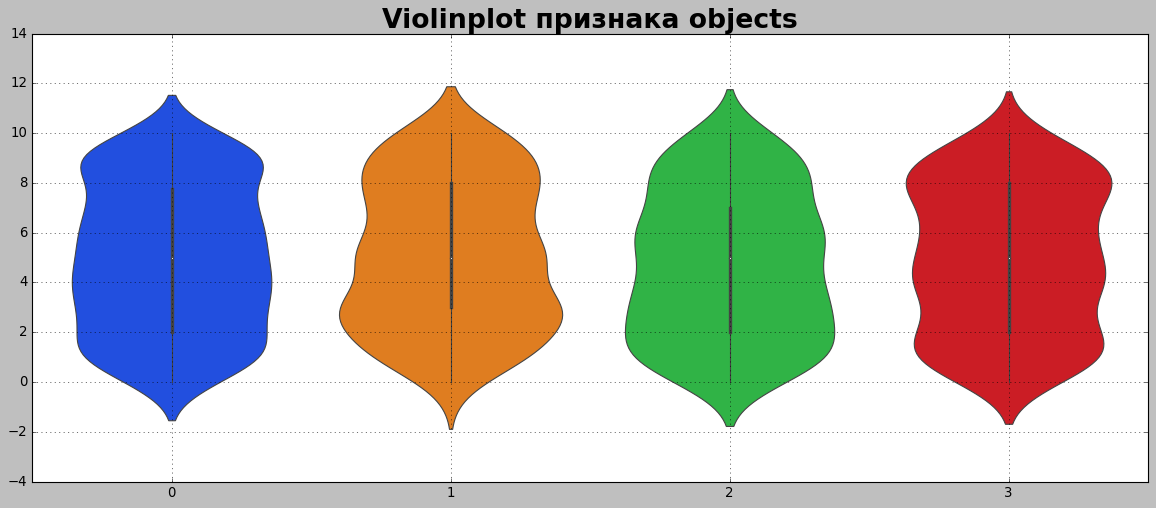

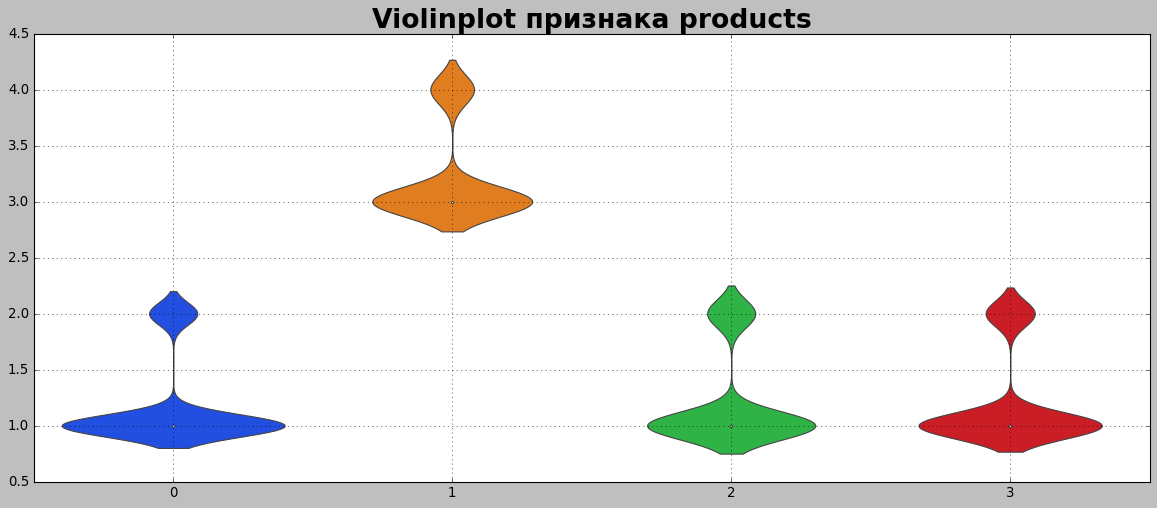

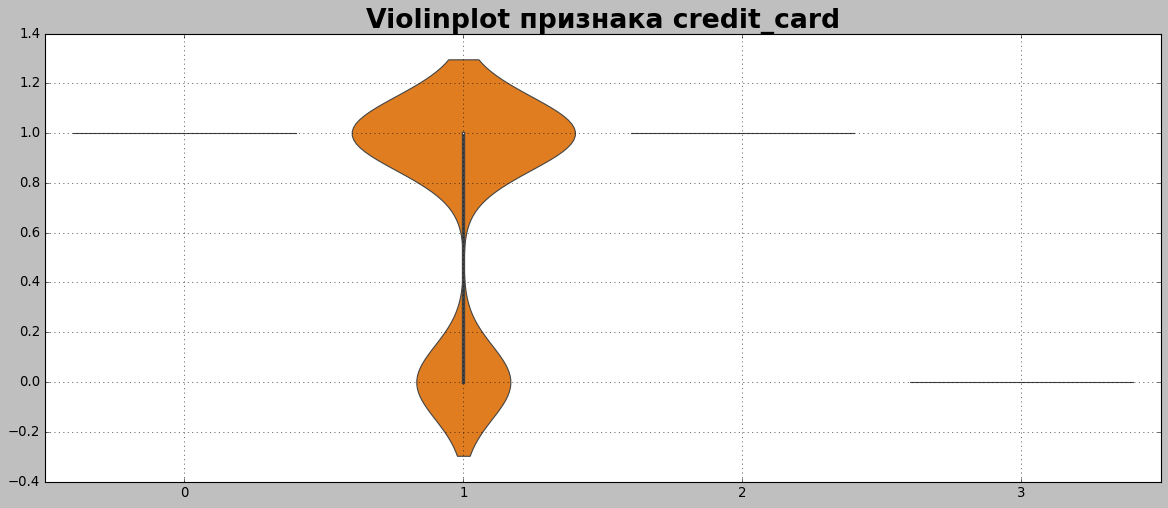

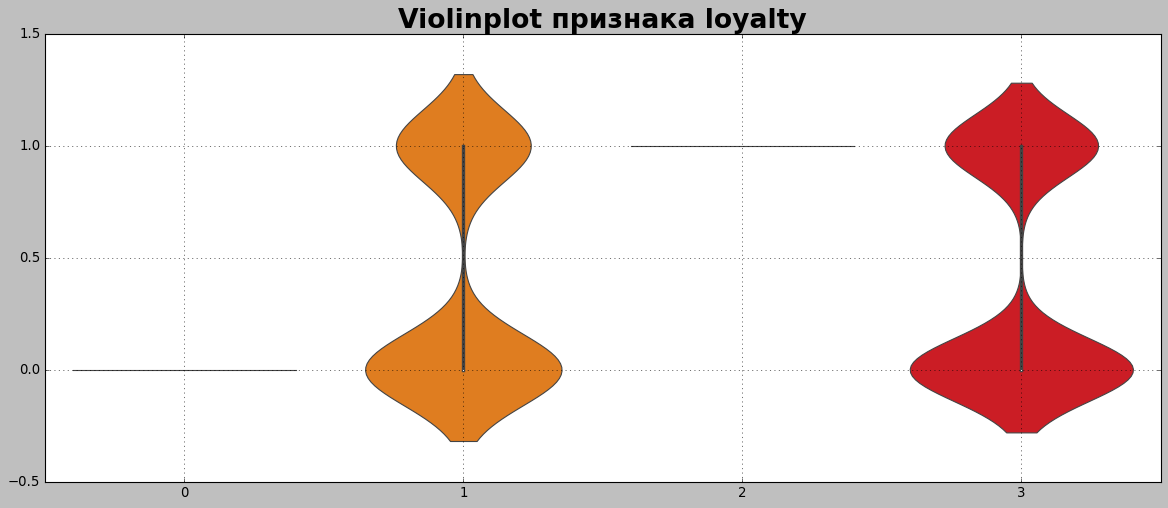

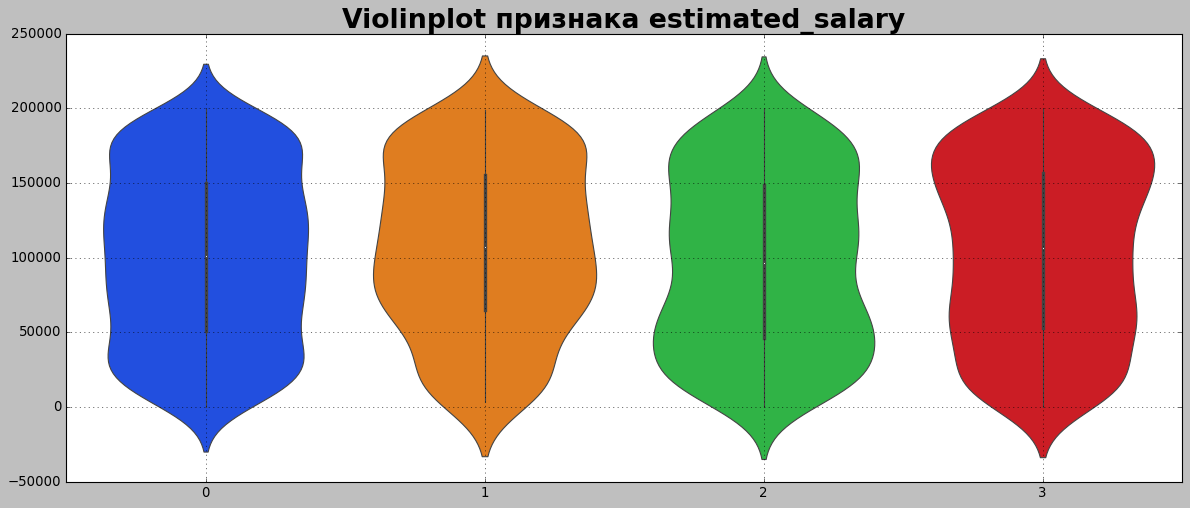

In [40]:
for c in clusters.drop(columns='cluster').columns:
    plt.figure(figsize=(18, 7))
    sns.violinplot(y=clusters[c], x=clusters['cluster'], palette='bright')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.title(f'Violinplot признака {c}', fontsize=24, color='black', fontweight='semibold')
    plt.grid()
    plt.show()

<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='summary'> [6. ВЫВОДЫ.](#summary-2) </a></b></font>

- По результатам статистического анализа были получены значимые различия средних значений признаков age, products, gender и loaylity между группами ушедших и оставшихся клиентов. Можно утверждать, что "средний ушедший" клиент старше, пользуется меньшим количеством продуктов и реже является активным клиентом. Также среди ушедших клиентов выше доля женщин.
- Аналогичных различий для признака estimated_salary обнаружено не было.
- Также могут быть различия в распределении ушедших/оставшихся клиентов по городам, но это проверить статистически не удалось.
    
Кроме того, в ходе кластерного анализа выделены следующие группы внутри именно ушедших клиентов:    
- Кластер 0: клиенты, пользовавшиеся большим количеством кредитных продуктов (самый маленький кластер).
- Кластер 1: активные (лояльные), но тем не менее ушедшие клиенты.
- Кластер 2: неактивные женщины.
- Кластер 3: неактивные мужчины.
    
</div>

In [41]:
std_1 = []

for c in features['feature']:
    if df[c].dtypes in ['int64', 'float64']:
        std_1.append(round(df.query('churn == 1')[c].std(), 2))
    else:
        std_1.append(np.nan)
        
features['std_1'] = std_1

features[['feature', 'mean_1', 'std_1']]

,feature,mean_1,std_1
0,user_id,NaN,NaN
1,estimated_salary,101465.68,57912.42
2,balance,120746.97,30555.19
3,score,645.35,100.32
4,age,44.84,9.76
5,objects,4.93,2.94
6,products,1.48,0.80
7,city,NaN,NaN
8,gender,0.44,0.50
9,credit_card,0.70,0.46


<div style="border-radius: 15px; border: 3px solid black; padding: 15px;">
    
<font size=+2><b><a name='conclusion'> [7. ЗАКЛЮЧЕНИЕ.](#conclusion-2) </a></b></font>

Учитывая вышеоописанные различия, можно описать портрет типичного уходящего из банка клиента: ему 35-55 лет, он пользуется 1-2 банковскими продуктами, имеет баланс в диапазоне 90к-151к рублей, доход в диапазоне 45-159к рублей и кредитный рейтинг в диапазоне 545-746 очков. Он скорее имеет кредитную карту и скорее не является активным пользователем банка в последнее время.   
    
По итогам данного проекта я попытался сформулировать следующие рекомендации:
- Обратить внимание на неактивных пользователей. Здесь можно продумать стратегию оповещения неактивных пользователей по разным каналам связи (уведомления в мобильном приложении, СМС, e-mail) о новых выгодных предложениях от банка. Или же напоминать о старых проверенных продуктах: например, о пролонгации вклада. Кроме того, вряд ли ушедшие клиенты перестают пользоваться банками; скорее всего, они уходят к конкурентам. Поэтому изучение поведения конкурентов и своевременная реакция на их предложения тоже будет полезна.
- Обратить внимание на сегмент клиентов 35-55 лет: это немолодые клиенты (и уже имеющие 1-2 банковских продукта), скорее всего, пользующиеся услугами банка уже значительное время. Для них можно было продумать/улучшить программу лояльности; возможно - несколько более выгодные условия по реструктуризации кредитов или открытию новых продуктов. Опять же, учитывая что это немолодой сегмент, есть смысл изучить ипотечные продукты: возможно, клиенты уходят в другие банки, в т.ч. и для взятия ипотеки.
- Также интересно, что ушедшие клиенты банка имеют высокие доходы по меркам Ярославской области (по информации из открытых источников). Скорее всего, такие клиенты задумываются о сбережении своих средств. Следовательно, им можно предложить выгодные (для их денежного остатка) вклады. Также можно подумать об инвестиционных продуктах: разработать свои или найти банки-партнеры для подлючения к их программам по инвестициям.
    
Также в дальнейшем интересно было бы изучить первые два кластера ушедших клиентов:
- Что заставило перестать пользоваться услугами банка клиентов с большим количеством продуктов? По результатам сравнения средних,  в общей своей массе ушедшие клиенты наоборот, имеют меньше продуктов чем оставшиеся. Возможно, есть некое "критическое значение" продуктов, при достижение которого клиент перестаёт пользоваться банковскими услугами (например, в силу навязчивости). Или же дело в других признаках, не представленных в изученных данных: например, могут уходить клиенты с несколькими кредитами, реструктурируя их в других банках.
- Что заставило уйти активных клиентов? Тут опять же, могут играть решающую роль пока неназванные данные: можно предположить, что клиенты уходят после выгодных предложений от других банков или перестают пользоваться зарплатной картой в связи со сменой работы.
    
</div>